In [141]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import cross_val_score         #用随机森林进行特征选择
from sklearn.linear_model import Ridge                      #线性回归模型
#import lightgbm as lgb
from sklearn.model_selection import train_test_split        #
import xgboost as xgb 
from xgboost import plot_importance                         #用xgb的方法进行特征重要性筛选

In [142]:
#读取数据集
train_df = pd.read_csv("../input/train_data.csv",index_col=0)
test_df = pd.read_csv("../input/test_a.csv",index_col=0)

In [143]:
#feat_labels = train_df.columns[0:2]
#feat_labels.head()

In [144]:
train_df.head(5)
#train_df.shape

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,region,...,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney
ID,,,,,,,,,,,,,,,,,,,,,
100309852,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,SH,RG00001,...,0,0.0000,28248,614,111546,1124.0,284.0,0,2018/11/28,2000.0
100307942,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,SH,RG00002,...,0,0.0000,14823,148,157552,701.0,22.0,1,2018/12/16,2000.0
100307764,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,SH,RG00002,...,0,0.0000,77645,520,131744,57.0,20.0,1,2018/12/22,16000.0
100306518,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,SH,RG00002,...,332760000,3080.0331,8750,1665,253337,888.0,279.0,9,2018/12/21,1600.0
100305262,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,SH,RG00003,...,0,0.0000,800,117,125309,2038.0,480.0,0,2018/11/18,2900.0


In [145]:
#test_df.head(10)
#test_df.shape

In [146]:
train_df["tradeMoney"].sort_values(ascending =True).head(10)      #true表示升序,false表示降序

ID
100279227      0.0
100090432      0.0
100304665      0.0
100302973      0.0
100304683      0.0
100073193      0.0
100276327      0.0
100281933      0.0
100305713      0.0
100020818    100.0
Name: tradeMoney, dtype: float64

In [147]:
#train_df(train_df["tradeMoney"]>1000000).value_counts(ascending =False)
train_df["tradeMoney"].sort_values(ascending =False).head(10)

ID
100007093    99999999.99
100028451    50000000.00
100042658    10000000.00
100022073      450000.00
100047710      450000.00
100084542      450000.00
100310820      450000.00
100012093      430000.00
100083675      380000.00
100089204      370000.00
Name: tradeMoney, dtype: float64

tradeMoney有离群点,对该列特征进行处理

In [1]:
mean_tradeMoney = train_df["tradeMoney"].mean()
train_df.loc[train_df["tradeMoney"] == 99999999.99,"tradeMoney"] = mean_tradeMoney
train_df.loc[train_df["tradeMoney"] == 50000000.00,"tradeMoney"] = mean_tradeMoney
train_df.loc[train_df["tradeMoney"] == 10000000.00,"tradeMoney"] = mean_tradeMoney

方法二:筛选交易额在100-10w之间的数据

In [2]:
train_data = train_df[(train_df["tradeMoney"]>100)&(train_df["tradeMoney"]<100000)].copy()
print(train_data.shape[0])

NameError: name 'train_df' is not defined

由此可见 测试集比训练集少了一列特征"tradeMoney",这就是我们测试集所要预测的label值

In [152]:
y_train = train_data[["tradeMoney"]].copy()
y_train.head()
print(y_train.shape)

(40992, 1)


In [153]:
print(y_train.shape)

(40992, 1)


In [154]:
train_data.drop('tradeMoney',axis=1, inplace=True) 

合并训练集和测试集,以方便进行处理

In [155]:
all_df = pd.concat((train_data, test_df), axis=0)

In [156]:
all_df.shape

(43461, 49)

In [157]:
#all_df.info()  #由此可见,除了"uv"特征和"pv"特征缺失20个以外,其他的不存在空的特征,因此无需对数据集进行填充.
all_df.isnull().sum().sort_values(ascending=False).head(10)

uv                  20
pv                  20
tradeTime            0
buildYear            0
gymNum               0
drugStoreNum         0
hospitalNum          0
privateSchoolNum     0
schoolNum            0
interSchoolNum       0
dtype: int64

In [158]:
#all_df["area"].value_counts()
#"area"特征样数比较多,但是没法处理,暂时舍弃
#all_df.drop('area',axis=1, inplace=True)  

In [159]:
all_df["rentType"].value_counts()

未知方式    32656
整租       5722
合租       5078
--          5
Name: rentType, dtype: int64

In [160]:
#all_df.drop('rentType',axis=1, inplace=True)   #由于"rentType"这一列特征缺失值太多,所以直接删除这一列特征

In [161]:
all_df.head()

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,region,...,tradeLandArea,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime
ID,,,,,,,,,,,,,,,,,,,,,
100309852,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,SH,RG00001,...,0.0,0,0.0000,28248,614,111546,1124.0,284.0,0,2018/11/28
100307942,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,SH,RG00002,...,0.0,0,0.0000,14823,148,157552,701.0,22.0,1,2018/12/16
100307764,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,SH,RG00002,...,0.0,0,0.0000,77645,520,131744,57.0,20.0,1,2018/12/22
100306518,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,SH,RG00002,...,108037.8,332760000,3080.0331,8750,1665,253337,888.0,279.0,9,2018/12/21
100305262,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,SH,RG00003,...,0.0,0,0.0000,800,117,125309,2038.0,480.0,0,2018/11/18


In [162]:
#提取特征一:"houseType"
all_df["houseType"].unique()  #查看一下,一共有多少种类型

array(['2室1厅1卫', '3室2厅2卫', '1室1厅1卫', '3室2厅3卫', '4室3厅3卫', '3室2厅1卫',
       '3室1厅1卫', '2室2厅1卫', '5室2厅3卫', '2室1厅2卫', '4室2厅2卫', '1室0厅1卫',
       '4室2厅3卫', '2室2厅2卫', '2室0厅1卫', '1室2厅1卫', '6室3厅4卫', '4室2厅4卫',
       '4室2厅1卫', '5室3厅5卫', '4室3厅2卫', '1室0厅0卫', '6室3厅2卫', '5室2厅2卫',
       '5室2厅4卫', '1室1厅2卫', '4室1厅3卫', '3室0厅1卫', '5室3厅4卫', '5室5厅4卫',
       '4室3厅5卫', '4室3厅4卫', '0室0厅1卫', '5室2厅5卫', '7室2厅3卫', '3室2厅4卫',
       '3室3厅2卫', '3室1厅2卫', '5室4厅5卫', '5室3厅3卫', '5室2厅6卫', '5室3厅1卫',
       '3室4厅4卫', '6室2厅4卫', '6室1厅4卫', '3室1厅3卫', '6室2厅3卫', '5室4厅3卫',
       '2室2厅3卫', '4室1厅1卫', '5室1厅1卫', '1室2厅2卫', '6室1厅1卫', '4室1厅2卫',
       '5室3厅6卫', '4室2厅5卫', '6室2厅2卫', '5室1厅2卫', '5室4厅4卫', '2室3厅1卫',
       '6室4厅2卫', '7室1厅7卫', '3室3厅4卫', '3室2厅5卫', '6室3厅5卫', '4室0厅1卫',
       '5室4厅2卫', '7室4厅3卫', '6室3厅3卫', '6室2厅5卫', '6室2厅7卫', '4室0厅4卫',
       '2室2厅0卫', '3室3厅3卫', '8室3厅4卫', '6室2厅6卫', '1室1厅0卫', '2室1厅0卫',
       '5室3厅2卫', '5室2厅1卫', '2室0厅0卫', '7室1厅1卫', '6室2厅1卫', '8室2厅4卫',
       '7室2厅1卫', '2室0厅2卫', '3室0厅2卫', '4室0厅2卫', '3室1厅0卫', '3室0厅

查看数据集的函数: head,  info,  unique,  describe,  sort_values(),  value_counts(),  dtypes()

In [163]:
#提取特征二:"houseFloor"
all_df["houseFloor"].unique()

array(['低', '中', '高'], dtype=object)

In [164]:
#用replace替换得到的1,2,3是object类型
#all_df["houseFloor"] =all_df["houseFloor"].replace("低",1)
#all_df["houseFloor"] =all_df["houseFloor"].replace("中",2)
#all_df["houseFloor"] =all_df["houseFloor"].replace("高",3)
all_df.loc[all_df["houseFloor"] == "低","houseFloor"] = 0
all_df.loc[all_df["houseFloor"] == "中","houseFloor"] = 1
all_df.loc[all_df["houseFloor"] == "高","houseFloor"] = 2

In [165]:
all_df["houseFloor"].unique()

array([0, 1, 2], dtype=int64)

In [166]:
#提取特征三:"totalFloor
all_df["totalFloor"].unique()

array([16, 14, 32, 17,  2,  5,  6,  7, 18, 21,  1,  3, 19, 29, 12,  8,  4,
       22, 30, 20, 24, 25, 26, 28, 15, 10, 11, 13, 33,  9, 23, 37, 27, 56,
       38, 40, 60, 35, 49, 41, 31, 62, 36, 53, 59, 39, 43, 61, 34, 58, 51,
       45, 47,  0], dtype=int64)

In [167]:
all_df["houseToward"].value_counts()
#没法处理暂时舍去
#all_df.drop('houseToward',axis=1, inplace=True) 
all_df["houseToward"]=all_df["houseToward"].replace("暂无数据","南")
all_df["houseToward"].value_counts()

南     36847
南北     2759
北      1980
东南      653
东       541
西南      322
西       268
西北       67
东西       24
Name: houseToward, dtype: int64

In [168]:
all_df["houseDecoration"].value_counts()  
#缺失值有点多,这个特征比较重要,但是目前没法处理,暂时舍去

其他    30742
精装    11136
简装     1270
毛坯      313
Name: houseDecoration, dtype: int64

In [169]:
#all_df.drop('houseDecoration',axis=1, inplace=True) 

In [170]:
all_df.head()

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,region,...,tradeLandArea,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime
ID,,,,,,,,,,,,,,,,,,,,,
100309852,68.06,未知方式,2室1厅1卫,0,16,南,其他,XQ00051,SH,RG00001,...,0.0,0,0.0000,28248,614,111546,1124.0,284.0,0,2018/11/28
100307942,125.55,未知方式,3室2厅2卫,1,14,南,简装,XQ00130,SH,RG00002,...,0.0,0,0.0000,14823,148,157552,701.0,22.0,1,2018/12/16
100307764,132.00,未知方式,3室2厅2卫,0,32,南,其他,XQ00179,SH,RG00002,...,0.0,0,0.0000,77645,520,131744,57.0,20.0,1,2018/12/22
100306518,57.00,未知方式,1室1厅1卫,1,17,南,精装,XQ00313,SH,RG00002,...,108037.8,332760000,3080.0331,8750,1665,253337,888.0,279.0,9,2018/12/21
100305262,129.00,未知方式,3室2厅3卫,0,2,南,毛坯,XQ01257,SH,RG00003,...,0.0,0,0.0000,800,117,125309,2038.0,480.0,0,2018/11/18


In [171]:
#all_df["communityName"].value_counts()   
#特征没法处理,暂时舍去
all_df.drop('communityName',axis=1, inplace=True) 

In [172]:
#all_df["city"].value_counts()
#由此可见,city只有一种,所以可以直接删去
all_df.drop('city',axis=1, inplace=True) 

In [173]:
all_df.head()

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,region,plate,buildYear,...,tradeLandArea,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime
ID,,,,,,,,,,,,,,,,,,,,,
100309852,68.06,未知方式,2室1厅1卫,0,16,南,其他,RG00001,BK00064,1953,...,0.0,0,0.0000,28248,614,111546,1124.0,284.0,0,2018/11/28
100307942,125.55,未知方式,3室2厅2卫,1,14,南,简装,RG00002,BK00049,2007,...,0.0,0,0.0000,14823,148,157552,701.0,22.0,1,2018/12/16
100307764,132.00,未知方式,3室2厅2卫,0,32,南,其他,RG00002,BK00050,暂无信息,...,0.0,0,0.0000,77645,520,131744,57.0,20.0,1,2018/12/22
100306518,57.00,未知方式,1室1厅1卫,1,17,南,精装,RG00002,BK00051,暂无信息,...,108037.8,332760000,3080.0331,8750,1665,253337,888.0,279.0,9,2018/12/21
100305262,129.00,未知方式,3室2厅3卫,0,2,南,毛坯,RG00003,BK00044,暂无信息,...,0.0,0,0.0000,800,117,125309,2038.0,480.0,0,2018/11/18


提取特征六:"region",直接one_hot处理

In [174]:
#all_df["region"].value_counts()

提取特征七:"plate"

In [175]:
all_df["plate"].unique()

array(['BK00064', 'BK00049', 'BK00050', 'BK00051', 'BK00044', 'BK00052',
       'BK00031', 'BK00028', 'BK00017', 'BK00045', 'BK00027', 'BK00041',
       'BK00047', 'BK00009', 'BK00025', 'BK00024', 'BK00014', 'BK00042',
       'BK00046', 'BK00043', 'BK00026', 'BK00013', 'BK00012', 'BK00005',
       'BK00011', 'BK00010', 'BK00003', 'BK00033', 'BK00053', 'BK00006',
       'BK00004', 'BK00002', 'BK00007', 'BK00015', 'BK00016', 'BK00019',
       'BK00030', 'BK00048', 'BK00018', 'BK00008', 'BK00029', 'BK00035',
       'BK00036', 'BK00022', 'BK00023', 'BK00065', 'BK00054', 'BK00038',
       'BK00037', 'BK00034', 'BK00058', 'BK00066', 'BK00039', 'BK00057',
       'BK00020', 'BK00059', 'BK00060', 'BK00063', 'BK00055', 'BK00061',
       'BK00040', 'BK00056', 'BK00062', 'BK00021', 'BK00032', 'BK00001'],
      dtype=object)

提取特征八:"buildYear"

In [176]:
all_df.loc[all_df["buildYear"] == "暂无信息","buildYear"] = 0

In [177]:
#all_df["buildYear"].value_counts()
all_df["buildYear"] =all_df["buildYear"].astype(int)
mean_col = all_df["buildYear"].mean()
print("-----------------------------------")
all_df["buildYear"] = all_df["buildYear"].replace(0,mean_col).astype(int)
all_df["buildYear"].unique()

-----------------------------------


array([1953, 2007, 1871, 2003, 1997, 1993, 1994, 1998, 2000, 1995, 1999,
       2015, 1981, 2014, 2002, 2010, 2011, 1989, 1983, 2001, 2012, 1996,
       2004, 2006, 2009, 2008, 1984, 2017, 1976, 1986, 1988, 1992, 2005,
       1987, 2016, 1965, 1990, 1985, 1978, 2013, 1980, 1954, 1982, 1968,
       1940, 1966, 1970, 1937, 1979, 1974, 1964, 1991, 1977, 1956, 1930,
       1952, 1957, 1936, 1967, 1972, 1955, 1949, 1912, 1958, 1973, 1932,
       1975, 1963, 1931, 1926, 1939, 1951, 1960, 1910, 1969, 1920, 1959,
       1962, 1961, 1950], dtype=int64)

后边特征都是数值型,不需要进行one_hot处理,只需处理日期和填补缺失值

In [178]:
#all_df["uv"].describe()
all_df["uv"] = all_df["uv"].fillna(all_df["uv"].mean())
#all_df["pv"].dtypes
all_df["pv"] = all_df["pv"].fillna(all_df["pv"].mean())
all_df.isnull().sum().sort_values(ascending=False).head(10)

tradeTime           0
subwayStationNum    0
shopNum             0
bankNum             0
gymNum              0
drugStoreNum        0
hospitalNum         0
privateSchoolNum    0
schoolNum           0
interSchoolNum      0
dtype: int64

In [179]:
#日期很重要,但是暂时不知道怎么处理,后期再说
#all_df["tradeTime"] = pd.to_datetime(all_df["tradeTime"],format ="%Y/%m/%d")
#all_df["tradeTime"] = pd.to_datetime(all_df['tradeTime'],infer_datetime_format=True)
all_df.drop('tradeTime',axis=1, inplace=True)

In [180]:
all_df.head()

,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,region,plate,buildYear,...,tradeLandNum,tradeLandArea,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum
ID,,,,,,,,,,,,,,,,,,,,,
100309852,68.06,未知方式,2室1厅1卫,0,16,南,其他,RG00001,BK00064,1953,...,0,0.0,0,0.0000,28248,614,111546,1124.0,284.0,0
100307942,125.55,未知方式,3室2厅2卫,1,14,南,简装,RG00002,BK00049,2007,...,0,0.0,0,0.0000,14823,148,157552,701.0,22.0,1
100307764,132.00,未知方式,3室2厅2卫,0,32,南,其他,RG00002,BK00050,1871,...,0,0.0,0,0.0000,77645,520,131744,57.0,20.0,1
100306518,57.00,未知方式,1室1厅1卫,1,17,南,精装,RG00002,BK00051,1871,...,1,108037.8,332760000,3080.0331,8750,1665,253337,888.0,279.0,9
100305262,129.00,未知方式,3室2厅3卫,0,2,南,毛坯,RG00003,BK00044,1871,...,0,0.0,0,0.0000,800,117,125309,2038.0,480.0,0


In [181]:
print(y_train.shape)

(40992, 1)


In [182]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
x, y = train_data.iloc[:, 12:40].values, train_data.iloc[:, 48].values

x_train, x_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)
feat_labels = train_df.columns[12:40]
forest = RandomForestClassifier(n_estimators=10, random_state=0, n_jobs=-1)
forest.fit(x_train, Y_train)


importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(x_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

print(x_train.shape[1])

 1) saleSecHouseNum                0.426953
 2) totalTradeMoney                0.056186
 3) totalTradeArea                 0.050954
 4) tradeSecNum                    0.047991
 5) tradeMeanPrice                 0.045113
 6) totalNewTradeArea              0.040211
 7) remainNewNum                   0.038997
 8) totalNewTradeMoney             0.036480
 9) tradeNewMeanPrice              0.033256
10) tradeNewNum                    0.031143
11) shopNum                        0.015130
12) busStationNum                  0.014267
13) drugStoreNum                   0.013642
14) schoolNum                      0.013372
15) superMarketNum                 0.013025
16) bankNum                        0.012917
17) supplyNewNum                   0.012810
18) parkNum                        0.012518
19) gymNum                         0.011978
20) subwayStationNum               0.011617
21) mallNum                        0.011149
22) privateSchoolNum               0.010674
23) hospitalNum                 

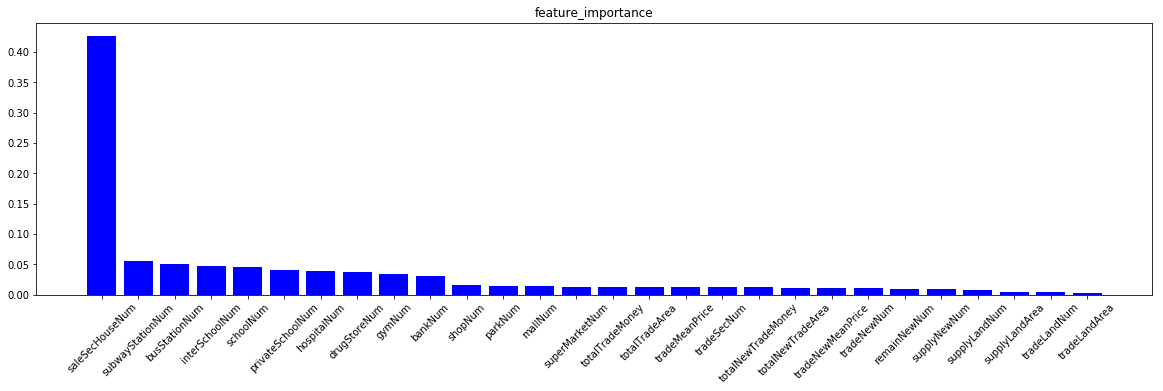

In [183]:
import matplotlib.pyplot as plt
#plt.title("feature_importance")
#plt.bar(range(x_train.shape[1]),importances[indices],color = "lightblue",align = "center")
#plt.xticks(,feat_labels,rotation = 90)
#plt.xlim([-1,x_train.shape[1]])
#plt.tight_layout()
#ply.show()
#以下代码参考泰坦尼克号案例
fig = plt.figure(figsize=(20,5))
plt.title("feature_importance")
plt.bar(range(x_train.shape[1]), importances[indices],color = "blue",align = "center")
plt.xticks(range(x_train.shape[1]), feat_labels, rotation=45)
plt.show()

In [184]:
feature =all_df[["area","houseType","houseFloor","totalFloor","houseToward","region","plate","buildYear","subwayStationNum","saleSecHouseNum"]].copy()

In [185]:
all_dummy_df = pd.get_dummies(feature)
all_dummy_df.head()

,area,houseFloor,totalFloor,buildYear,subwayStationNum,saleSecHouseNum,houseType_0室0厅1卫,houseType_1室0厅0卫,houseType_1室0厅1卫,houseType_1室1厅0卫,...,plate_BK00057,plate_BK00058,plate_BK00059,plate_BK00060,plate_BK00061,plate_BK00062,plate_BK00063,plate_BK00064,plate_BK00065,plate_BK00066
ID,,,,,,,,,,,,,,,,,,,,,
100309852,68.06,0,16,1953,7,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
100307942,125.55,1,14,2007,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100307764,132.00,0,32,1871,6,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100306518,57.00,1,17,1871,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100305262,129.00,0,2,1871,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [186]:
print(y_train.shape)

(40992, 1)


In [187]:
dummy_train_df = all_dummy_df.loc[train_data.index]   #one_hot处理后的训练集
dummy_test_df = all_dummy_df.loc[test_df.index]     #one_hot处理后的测试集

In [188]:
#print(dummy_train_df.shape)
y_train.shape

(40992, 1)

# 建立模型

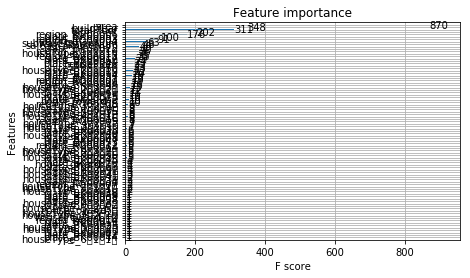

In [189]:

X_train, X_test, y_train, y_test = train_test_split(dummy_train_df, y_train, test_size=0.2, random_state=0)
 
model = xgb.XGBRegressor(
    max_depth=5, 
    learning_rate=0.1, 
    n_estimators=160, 
    silent=True, 
    objective='reg:gamma')
model.fit(X_train, y_train)
 
# 对测试集进行预测
ans = model.predict(X_test)
 
# 显示重要特征
plot_importance(model)
plt.show()

In [190]:
y_pro = model.predict(dummy_test_df)

In [191]:
submission_df = pd.DataFrame(data = y_pro)
#submission_df.head()

In [192]:
submission_df.to_csv("C:/Users/Administrator/future/output/submit.csv",index =None,header =None)

In [193]:
submission_df.head(5)

,0
0,3632.358887
1,5075.744141
2,6038.988281
3,3664.843994
4,4767.038574
